In [1]:
from __future__ import division
from brian2 import *
import numpy as np
import scipy.io
import scipy.sparse
from sklearn import linear_model
import scipy.sparse.linalg

from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.preprocessing import normalize
import scipy.signal
import itertools
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from multiprocessing import Pool

import time

import os

os.chdir('/Users/liutianlin/Desktop/Academics/MINDS/neuromorphic/reservoir_Demo/ECG/data/')


/Users/liutianlin/anaconda3/lib/python3.6/site-packages/brian2/core/variables.py:174: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  return np.issubdtype(np.bool, self.dtype)


In [2]:
def read_Dynapse_data(coreID,neuronID,Tm):
    core_id_array = []
    with open(coreID, 'r') as f:
        for line in f:
            core_id_array.append(int(line))
        core_id_array = np.array(core_id_array)
    
    neuron_id_array = []
    with open(neuronID, 'r') as f:
        for line in f:
            neuron_id_array.append(int(line))
        neuron_id_array = np.array(neuron_id_array)


    time_array = []
    with open(Tm, 'r') as f:
        for line in f:
            time_array.append(int(line))
        time_array = np.array(time_array)
    
    neuron_id_array0=neuron_id_array[core_id_array==0]
    time_array0=time_array[core_id_array==0]
    pulse_ts = time_array0[neuron_id_array0==1]

    t_min = np.min(time_array)
    t_max = np.max(time_array)

    unit_t = 10**(-6)*second
        
    neuron_id_array = (core_id_array-1)*256+neuron_id_array
    reservoir_neurons = neuron_id_array[core_id_array!=0]
    spike_times = time_array[core_id_array!=0]

    print(reservoir_neurons.shape)
    print(spike_times.shape)
    
    return reservoir_neurons, spike_times

def exp_smooth(spike_train, t_grid, alpha=2, inc = 1):
    n_spike = len(spike_train)
    n_t = len(t_grid)
    i_spike = 0
    i_t = 0
    sig = 0
    sig_list = []
    sig_t =0
    while i_t < n_t:
        if i_spike >= n_spike:
            delta_t = unit_t * (t_grid[i_t] - sig_t)/second
            sig = sig/np.exp(alpha*delta_t)
            sig_list.append(sig)
            sig_t = t_grid[i_t]
            i_t += 1
        elif spike_train[i_spike] < t_grid[i_t]:
            delta_t = unit_t * (spike_train[i_spike] - sig_t)/second
            sig = sig/np.exp(alpha*delta_t)+inc
            sig_t = spike_train[i_spike]
            i_spike += 1
        else:
            delta_t = unit_t * (t_grid[i_t] - sig_t)/second
            sig = sig/np.exp(alpha*delta_t)
            sig_list.append(sig)
            sig_t = t_grid[i_t]
            i_t += 1
    return sig_list   
  

  
    
def read_ECG(MatECG):
	rate = scipy.io.loadmat(MatECG)
	rate_key = list(rate.keys())
	ecg_key = rate_key[3]
	ecg_raw = rate[ecg_key]
	return ecg_raw


def read_target(trgtMat):
	rate = scipy.io.loadmat(trgtMat)
	rate_key = list(rate.keys())
	trgt_key = rate_key[3]
	trgt_raw = rate[trgt_key]
	return trgt_raw


def confusion_stat(confusion):
	TP = confusion[1,1]
	FN = confusion[1,0]
	FP = confusion[0,1]
	TN = confusion[0,0]
	#Accuracy 
	ACC = (TP + TN ) / (TP + FP + TN + FN)
	# sensitivity (recall)
	SEN = TP/(TP + FN)
	# precision
	PRE = TP/(TP + FP)
	# F1 score
	F1 = (2 * TP) / (2 * TP + FP + FN)
	return ACC, SEN, PRE, F1
    
def binarize(y, thres):
	y_b = np.copy(y)
	y_b[y >= thres] = 1
	y_b[y < thres] = 0
	return y_b


# Load target

In [3]:
subjectNr = '223'

os.chdir('/Users/liutianlin/Desktop/Academics/MINDS/neuromorphic/reservoir_Demo/ECG/data/' + subjectNr)


inp = 'ECG_' + subjectNr
trgt = 'Target_' + subjectNr

beats = 'Beats_' + subjectNr


myRangeDict = {
'106' : np.arange(216000,540000),
'119' : np.arange(216000,540000),
'200' : np.arange(108000,432000),
'201' : np.arange(86400,410400),
'203' : np.arange(108000,432000),
'223' : np.arange(194400,518400),
'233' : np.arange(194400,518400)
}

myRange = myRangeDict[subjectNr] 


ecg = read_ECG(inp)[myRange] # the ecg signal in the range



rPeaks = scipy.io.loadmat(beats)[beats].flatten()[myRange] # the gaussians of peaks in the range


target = np.int_(read_target(trgt).flatten()[myRange]) # only first 15 min in this experiment


In [4]:
rPeaks = scipy.io.loadmat(beats)[beats].flatten()[myRange]

trainLength = 2 * 108000

rPeaks_train = rPeaks[:trainLength] 
rPeaks_test = rPeaks[trainLength:]
ecg_train = ecg[:trainLength] 
ecg_test = ecg[trainLength:] 

framesPerSecond = 9


rPeaks_train = rPeaks[:trainLength] 
rPeaks_test = rPeaks[trainLength:]

target_train_pre = target[:trainLength] 

target_test_pre = target[trainLength:]


target_train = target_train_pre[rPeaks_train.astype(int)==1]
target_test = target_test_pre[rPeaks_test.astype(int)==1]


In [5]:
%matplotlib tk

plotLim = 10000
plt.close()
plt.figure()
plt.plot(ecg[:plotLim])
plt.plot(rPeaks[:plotLim])
plt.plot(target[:plotLim])


# Load training data

In [5]:
trainDataName = 'train_subject_' + subjectNr

coreID = trainDataName + '_core_id.txt'
neuronID = trainDataName + '_neuron_id.txt'
Tm = trainDataName + "_ts.txt"

reservoir_neurons_train, spike_times_train = read_Dynapse_data(coreID,neuronID,Tm) 
spike_times_train = spike_times_train - spike_times_train[0]

unit_t = 10**(-6)*second


(3495544,)
(3495544,)


In [6]:
smoothingParameter = 15
delay = 0.1

def func_train(i):
    t_grid = (np.where(rPeaks_train.astype(int)==1)[0]/360 + delay) * 10**6
    return exp_smooth(spike_times_train[reservoir_neurons_train ==i], t_grid, alpha= smoothingParameter)


# p = Pool(20)
p = Pool(10)

start_time = time.time()
result = p.map(func_train, range(768)) 
sicTrain = np.array(result)
print("--- %s seconds ---" % (time.time() - start_time))


--- 41.58710289001465 seconds ---


# Do cross-validation

In [7]:
print('the length of the target: ', len(target_train))

the length of the target:  901


In [8]:
nFold = 3

# outSpanForTrainFold = int(len(target_train)/nFold)

outSpanForTrainFold = int(len(target_train)/nFold)

outAllIndices = set(np.arange(len(target_train)))


trainIndicesAllFolds = []
validationIndicesAllFolds = []

for foldnr in np.arange(nFold):
     
    validationIndices= list(range(foldnr * outSpanForTrainFold, (foldnr + 1) * outSpanForTrainFold))
    trainIndices = list(outAllIndices - set(validationIndices))
    validationIndicesAllFolds.append(validationIndices)
    trainIndicesAllFolds.append(trainIndices)


In [11]:
ACC_tr_all = []
SEN_tr_all = []
PRE_tr_all = []
F1_tr_all = []
ACC_ts_all = []
SEN_ts_all = []
PRE_ts_all = []
F1_ts_all = []

ridgeParameter = 500

binarize_thres = 0.4

In [12]:
for foldNr in np.arange(nFold):

    sicTrainFold = sicTrain[:,trainIndicesAllFolds[foldNr] ]
    sicValidationFold = sicTrain[:,validationIndicesAllFolds[foldNr] ]

    outTrainFold = target_train[trainIndicesAllFolds[foldNr]]
    outValidationFold = target_train[validationIndicesAllFolds[foldNr]]

    clf = Ridge(alpha = ridgeParameter)
    clf.fit(np.mat(sicTrainFold).T, outTrainFold)
    train_fold_prdct = clf.predict(np.mat(sicTrainFold).T )
    round_train_fold_prdct = binarize(train_fold_prdct, binarize_thres)

    
    validation_fold_prdct = clf.predict(np.mat(sicValidationFold).T)
    round_validation_fold_prdct = binarize(validation_fold_prdct, binarize_thres)

    cnf_matrix_train = confusion_matrix(outTrainFold, round_train_fold_prdct)
    cnf_matrix_validation = confusion_matrix(outValidationFold, round_validation_fold_prdct)

    # confusion stats
    ACC_tr, SEN_tr, PRE_tr, F1_tr = confusion_stat(cnf_matrix_train)
    ACC_ts, SEN_ts, PRE_ts, F1_ts = confusion_stat(cnf_matrix_validation)
    
    ACC_tr_all.append(ACC_tr)
    SEN_tr_all.append(SEN_tr)
    PRE_tr_all.append(PRE_tr)
    F1_tr_all.append(F1_tr)
    ACC_ts_all.append(ACC_ts)
    SEN_ts_all.append(SEN_ts)
    PRE_ts_all.append(PRE_ts)
    F1_ts_all.append(F1_ts)

print('========== subject', subjectNr,'===================')
print('binarize_thres', binarize_thres)
print('smoothing parameter', smoothingParameter)
print('ridge parameter', ridgeParameter)
print('------------------------------------------')
print('av ACC train', np.array(ACC_tr_all).mean())
print('av SEN train', np.array(SEN_tr_all).mean())
print('av PRE train', np.array(PRE_tr_all).mean())
print('av F1 train', np.array(F1_tr_all).mean())

print('av ACC validation', np.array(ACC_ts_all).mean())
print('av SEN validation', np.array(SEN_ts_all).mean())
print('av PRE validation', np.array(PRE_ts_all).mean())
print('av F1 validation', np.array(F1_ts_all).mean())    
print('==========================================')
    

========== subject 223 ===================
binarize_thres 0.4
smoothing parameter 15
ridge parameter 500
------------------------------------------
av ACC train 0.8896283971159179
av SEN train 0.675966520526106
av PRE train 0.8701126344458293
av F1 train 0.7587264041572604
av ACC validation 0.818888888888889
av SEN validation 0.6131607335490831
av PRE validation 0.6975987729412387
av F1 validation 0.6124516316150619


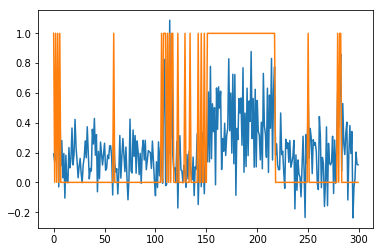

In [13]:
plt.plot(validation_fold_prdct)
plt.plot(outValidationFold)

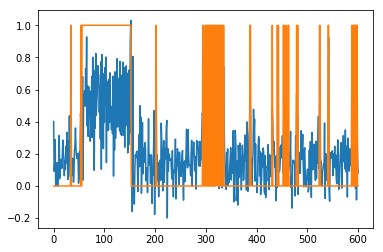

In [14]:
plt.plot(train_fold_prdct)
plt.plot(outTrainFold)

# Testing

In [15]:
dataName = 'test_subject_' + subjectNr
coreID = dataName + '_core_id.txt'
neuronID = dataName + '_neuron_id.txt'
Tm = dataName + "_ts.txt"

reservoir_neurons_test, spike_times_test = read_Dynapse_data(coreID,neuronID,Tm)
spike_times_test = spike_times_test - spike_times_test[0]


(1691821,)
(1691821,)


In [16]:
smoothingParameter_test =  smoothingParameter
def func_test(i):
    t_grid = (np.where(rPeaks_test.astype(int)==1)[0]/360 + delay) * 10**6
    return exp_smooth(spike_times_test[reservoir_neurons_test==i], t_grid, alpha= smoothingParameter_test)

from multiprocessing import Pool

p = Pool(10)
start_time = time.time()
sicTest = np.array(p.map(func_test, range(768))) 
print("--- %s seconds ---" % (time.time() - start_time))

--- 20.538533926010132 seconds ---


In [17]:
ridgeParameter_test =  ridgeParameter
binarize_thres_test = binarize_thres

clf = Ridge(alpha = ridgeParameter_test)
clf.fit(np.mat(sicTrain).T, target_train)

train_prdct = clf.predict(np.mat(sicTrain).T)

test_prdct = clf.predict(np.mat(sicTest).T)
round_train_prdct = binarize(train_prdct, binarize_thres_test)

round_test_prdct = binarize(test_prdct, binarize_thres_test)

In [18]:
better_cnf_matrix_train = confusion_matrix(target_train, round_train_prdct)
better_cnf_matrix_test = confusion_matrix(target_test, round_test_prdct)

# confusion stats
ACC_tr, SEN_tr, PRE_tr, F1_tr = confusion_stat(better_cnf_matrix_train)
ACC_ts, SEN_ts, PRE_ts, F1_ts = confusion_stat(better_cnf_matrix_test)




In [19]:
print('==============test========================')
print('============== subject', subjectNr, '==============')
print('smoothing parameter', smoothingParameter)
print('ridge parameter', ridgeParameter_test)
print('binarize parameter', binarize_thres_test)

print('------------------------------------------')
print('ACC all train', ACC_tr)
print('SEN all train', SEN_tr)
print('PRE all train', PRE_tr)
print('F1  all train', F1_tr)

print('ACC test', ACC_ts)
print('SEN test', SEN_ts)
print('PRE test', PRE_ts)
print('F1  test', F1_ts)    
print('==========================================')


==============test========================
============== subject 223 ==============
smoothing parameter 15
ridge parameter 500
binarize parameter 0.4
------------------------------------------
ACC all train 0.8856825749167592
SEN all train 0.6738197424892703
PRE all train 0.8532608695652174
F1  all train 0.7529976019184652
ACC test 0.9053117782909931
SEN test 0.7614678899082569
PRE test 0.8469387755102041
F1  test 0.8019323671497585


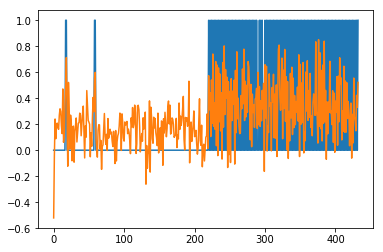

In [20]:
plt.plot(target_test)
plt.plot(test_prdct)

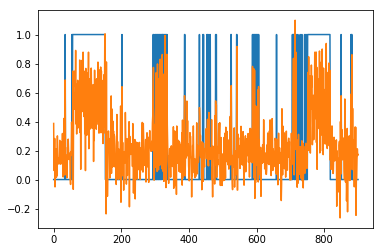

In [21]:
plt.plot(target_train)
plt.plot(train_prdct)